### In this notebook we want to explore the reviews and try to extract clues from the text. We will try to answer the question: can we find a way to classify negative and positive reviews based on text?


In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Gathering Data
s_listings = pd.read_csv('listings_seattle.csv')
s_reviews = pd.read_csv('reviews_seattle.csv')

b_listings = pd.read_csv('listings_boston.csv')
b_reviews = pd.read_csv('reviews_boston.csv')

In [35]:
# Assessing the data
s_reviews.date.dt.year.value_counts()

2015    52493
2014    20365
2013     7077
2012     3251
2011     1169
2010      254
2016      223
2009       17
Name: date, dtype: int64

In [15]:
s_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [18]:
# Some preprocessing prices and date from strings to float and datetime
def fix_price(x):
    """
    Convert price in string format with $ sign to a float
    input: a string including a price with optional $ symbol
    output: a float
    """
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)
    return x

#calendar['date'] = pd.to_datetime(calendar['date'])
#tf_dict = {'t':True, 'f':False}
#calendar['available'] = calendar['available'].map(tf_dict)
#calendar['price']=calendar['price'].apply(fix_price)

s_reviews['date']=pd.to_datetime(s_reviews['date'])
b_reviews['date']=pd.to_datetime(b_reviews['date'])

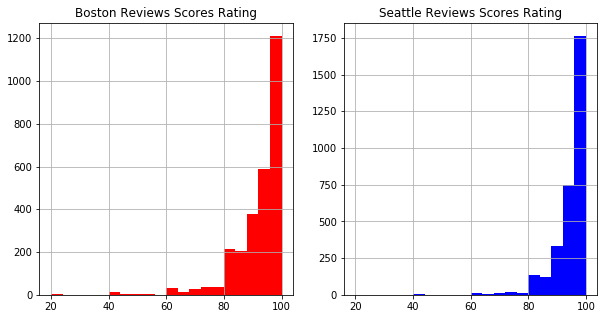

In [39]:
# We can use the listings dataset and the scores ratings to have an idea of what to expect from the reviews:

# Mostly positive reviews
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
b_listings['review_scores_rating'].sort_values().reset_index(drop=True).dropna().hist(color='red', bins=20)
plt.title('Boston Reviews Scores Rating');
plt.subplot(1,2,2)
s_listings['review_scores_rating'].sort_values().reset_index(drop=True).dropna().hist(color='blue', bins=20)
plt.title('Seattle Reviews Scores Rating');

The plots above show that the distrubution of the scores is skewed and most of the reviews are positive (scores are in the scale from 0 to 100)


We will start with something fun, like building a wordmap from the comments

In [4]:
# Generating  a wordmap from the comments
# Importing classes
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
def gen_wordcloud(reviews, mask_file):
    # drop rows without reviews
    reviews = reviews.dropna(subset=['comments'])
    text = " ".join(review for review in reviews.comments)
    # remove punctation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # remove stopwords
    stopwords = set(STOPWORDS)
    # generating wordcloud
    # Loading a mask from seattle
    
    mask = np.array(Image.open(mask_file))
    wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white",
                     mask=mask, margin=3, scale=2).generate(nopunc)

    return wordcloud

In [5]:
seattle_wc = gen_wordcloud(s_reviews,'seattle_mask.png')
boston_wc = gen_wordcloud(b_reviews,'boston-shape.png')

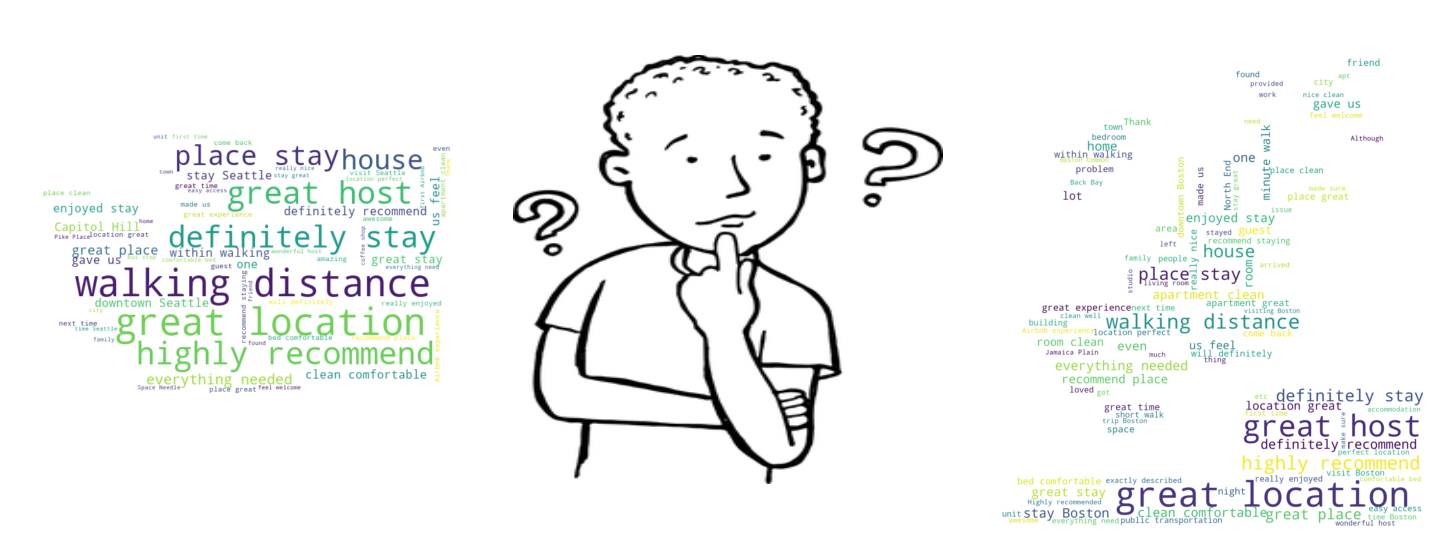

In [10]:
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
plt.imshow(seattle_wc, interpolation='bilinear')
plt.axis("off")
plt.subplot(1,3,2)
img = Image.open('wonder-thinker-pixabay.png')
#img.thumbnail((256, 256), Image.ANTIALIAS)
plt.imshow(img, aspect='equal', extent=[0,1,4,3], interpolation='bilinear')
plt.axis("off")
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(boston_wc, interpolation='bilinear')
plt.tight_layout()
plt.show()

### Can we find a way to classify negative and positive reviews based on text?
We will analyze the text in the reviews with what is called a "Sentiment Analysis", defined by wikipedia as "Opinion mining refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information".

We will use the Vader Sentiment Analyzer from the paper "VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text" by C.J. Hutto Eric Gilbert http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

VADER produces four sentiment metrics from these word ratings. The first three, positive, neutral and negative, represent the proportion of the text that falls into those categories. The final metric, the compound score, is the normalized sum of all of the lexicon ratings which have been standardised to range between -1 and 1. 

We can actually use our reviews dataset to check how well this algorithm does here. Since in the listings dataset we have a "review_scores_rating" (in a 0-100 scale) for each listing, after scoring the reviews with VADER we will groupby the reviews by listing and calculate the mean of the compound score. Then we will apply min-max normalization to these two values so that we can compare them, by showing the distribution of the abs values of the difference between the two.

In [39]:
#Importing libraries for the sentiment analyzer
# Modeling
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    """
    Prints the polarity scores from teh analyser
    input: a text sentence
    output: a list with the polarity scores (positivity, negativity, neutral, compound) of the sentence
    """
    snt = analyser.polarity_scores(sentence)
    #print("{:-<40} {}".format(sentence, str(snt)))
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/maurizio/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/Users/maurizio/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [119]:
# Cleaning Data
# Text preprocessing
# Using langdetect to detect the languages of the review: Port of Google’s [language-detection]
# (https://code.google.com/p/language-detection/) library (version from 03/03/2014) to Python.
# supports 55 languages out of the box

from langdetect import detect 
# Detect language of reviews and drop rows with non-english reviews
def safe_detect(text):
    """
    Detect language of the text
    input: a string with text
    output: the encoding of the language of the text (example 'en' for english), or 'None' if not found 
    """
    try:
        return(detect(text))
    except:
        return('None')

In [120]:
# We will remove all non-english reviews  
#reviews['language'] = reviews['comments'].apply(safe_detect)
def review_preprocessing(reviews):
    """
    Preprocessing of reviews airbnb dataframe
    input: dataframe of airbnb reviews
    output: dataframe with language column added, limited to rows with reviews in english
    """
    
    df = reviews.dropna(subset=['comments']).copy()
    df['language'] = df['comments'].apply(safe_detect)
    return df[df['language']=='en']


In [121]:
# This will take some time, better to save the files once done
rv_seattle = review_preprocessing(s_reviews)
rv_boston = review_preprocessing(b_reviews)

rv_seattle.to_csv('seattle_prep_reviews.csv')
rv_boston.to_csv('boston_prep_reviews.csv')

In [37]:
#rv_seattle = pd.read_csv('seattle_prep_reviews.csv')
#rv_boston = pd.read_csv('boston_prep_reviews.csv')

In [40]:
# Using the model 
# We add the polarity scores from Vader to the reviews datasets
# This might take a while too

seattle_scores = [[d['neg'], d['neu'], d['pos'], d['compound']] for d in rv_seattle.comments.apply(analyser.polarity_scores)]
rv_seattle = pd.concat([rv_seattle, pd.DataFrame(data = seattle_scores, columns=['negative', 'neutral', 'positive', 'compound'])], 
                                           axis=1)
boston_scores = [[d['neg'], d['neu'], d['pos'], d['compound']] for d in rv_boston.comments.apply(analyser.polarity_scores)]
rv_boston = pd.concat([rv_boston, pd.DataFrame(data = boston_scores, columns=['negative', 'neutral', 'positive', 'compound'])], 
                                           axis=1)
#rv_seattle.to_csv('seattle_prep_reviews.csv')
#rv_boston.to_csv('boston_prep_reviews.csv')

Now we can visualize the distributions of the sentiment indicators for both datasets. We don't expect major differences between Boston and Seattle

(0, 50000)

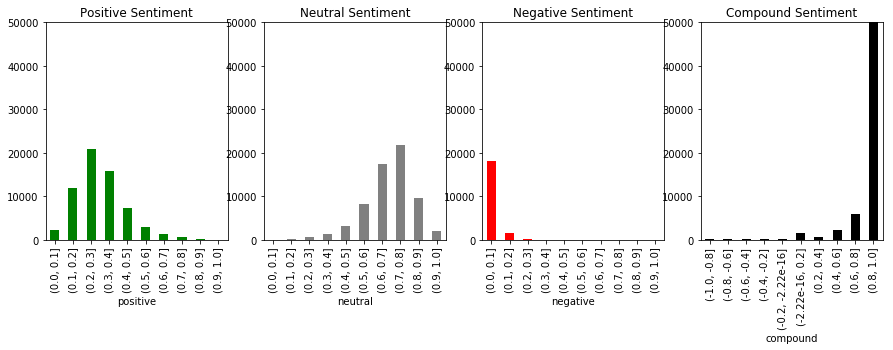

In [41]:
# Distributions for Boston
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
rv_boston.groupby(pd.cut(rv_boston["positive"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='green')
plt.title('Positive Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,2)
rv_boston.groupby(pd.cut(rv_boston["neutral"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='grey')
plt.title('Neutral Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,3)
rv_boston.groupby(pd.cut(rv_boston["negative"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='red')
plt.title('Negative Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,4)
rv_boston.groupby(pd.cut(rv_boston["compound"], np.arange(-1.0, 1.1, 0.2))).listing_id.count().plot(kind='bar', color='black')
plt.title('Compound Sentiment');
plt.ylim(0,50000)

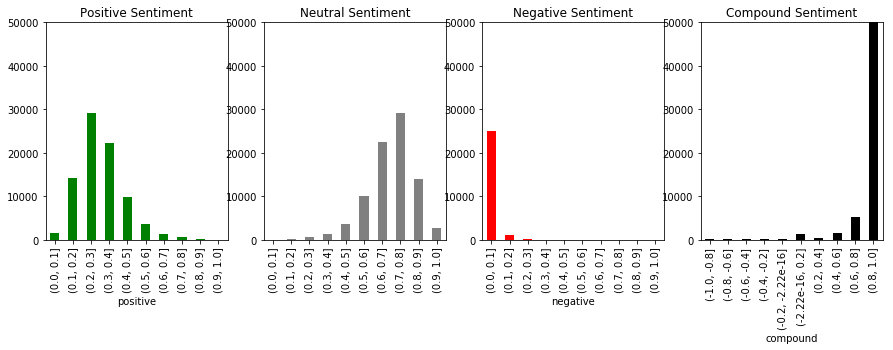

In [43]:
# Distributions for Seattle
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
rv_seattle.groupby(pd.cut(rv_seattle["positive"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='green')
plt.title('Positive Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,2)
rv_seattle.groupby(pd.cut(rv_seattle["neutral"]+rv_seattle["negative"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='grey')
plt.title('Neutral Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,3)
rv_seattle.groupby(pd.cut(rv_seattle["negative"], np.arange(0, 1.1, 0.1))).listing_id.count().plot(kind='bar', color='red')
plt.title('Negative Sentiment')
plt.ylim(0,50000)
plt.subplot(1,4,4)
rv_seattle.groupby(pd.cut(rv_seattle["compound"], np.arange(-1.0, 1.1, 0.2))).listing_id.count().plot(kind='bar', color='black')
plt.title('Compound Sentiment')
plt.ylim(0,50000);

If we have a look at the compound score we notice that Seattle guests are more generous in their comments, as more than 88% of them reach a compund score bigger than 0.8, copmared to only 63% of the Boston guests.

In [9]:

print(rv_seattle[rv_seattle["compound"]>0.8].listing_id.count()/rv_seattle.shape[0])
print(rv_boston[rv_boston["compound"]>0.8].listing_id.count()/rv_seattle.shape[0])

0.8884711330731312
0.634177200081164


The distributions of the sentiment indicators are quite similar between the two cities.
The plots show that only just over 6% of the reviews have a strong positive sentiment (>0.5) 
and the majority (61%) are in the 0.2 - 0.4 range, and most of the reviews are neutral (93%).
However the negative sentiment is very low as the majority of comments have negativity < 0.1
The compound score shows that 63% of the guests in Boston and more than 88% in Seattle give overall positive reviews.

### Comparing the Vader compound score to listings Review Scores rating
We will now compare the scores from the reviews with the ones in the listings to have an idea if the VADER algorithm worked well: we will compute the mean of the compound score from Vader for each listing. In order to compare the two values we will apply min-max normalization. Then we will plot the distribution of the difference between these two scores

In [172]:
# Calculate the mean of the compound score from Vader
comp_rev=rv_seattle.groupby(['listing_id'])[['compound']].mean().reset_index().merge(
    s_listings[['id', 'review_scores_rating']].dropna(), right_on='id', left_on='listing_id')

comp_rev.drop('id', axis=1, inplace=True)
comp_rev.set_index('listing_id', drop=True, inplace=True)
comp_rev.head()

,compound,review_scores_rating
listing_id,,
4291,0.797988,92.0
5682,0.888886,96.0
6606,0.914204,93.0
7369,0.904060,94.0
9419,0.902775,91.0


In [177]:
# Now we normalize two scores so that they can be compared, using min max normalization
def normalize(df):
    """
    Normalize the columns in the dataset containing compond score from Vader and rating score from airbnb
    input: a dataframe with listing_id, vader compound score (-1, 1) range and airbnb scores rating in (0,10) range
    output: a dataframe with normalized scores using min-max normalization
    """
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

normal_comp = normalize(comp_rev)
normal_comp.head()

,compound,review_scores_rating
listing_id,,
4291,0.899883,0.9000
5682,0.945726,0.9500
6606,0.958495,0.9125
7369,0.953379,0.9250
9419,0.952731,0.8875


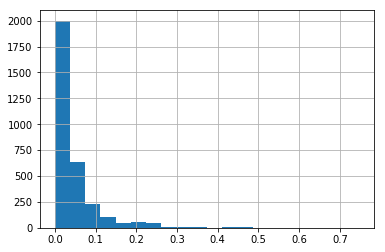

In [178]:
# Now we can compare the two:
# Differences, skewwd towards 0.3===> Good!!!

normal_comp['diff']=np.abs(normal_comp['compound'] - normal_comp['review_scores_rating'])
normal_comp['diff'].hist(bins=20)


So we can see that the distribution is skewed with most of the data below 0.1, confirming that the difference between the mean of the VADER compound score and the review_scores_rating for most of listings is below 10%.   